<a href="https://colab.research.google.com/github/sejongmin/AI/blob/main/%EC%8B%A4%EC%8A%B54_%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D_(RNN_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

import numpy as np

import random

## Time-series data 생성

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 40))  # 사인 곡선 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 10)) # 사인 곡선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # 잡음(noise)
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 100
series = generate_time_series(1000, n_steps + 1)
X_train, y_train = series[:900, :n_steps], series[:900, -1]
X_test, y_test = series[900:, :n_steps], series[900:, -1]

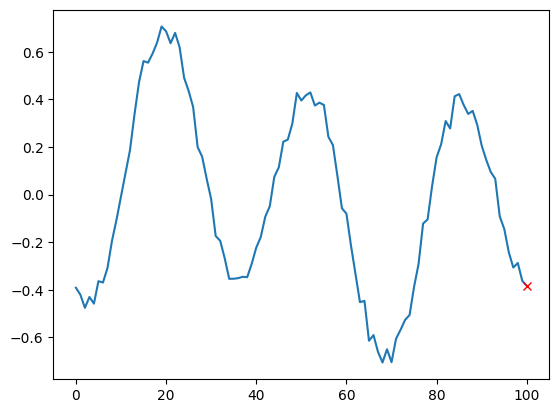

In [ ]:
import matplotlib.pyplot as plt

i = 2
plt.plot(series[i,:])
plt.plot(n_steps,series[i, -1], 'rx')
plt.show()

In [ ]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 텐서로 변환
X_train_ = torch.FloatTensor(X_train)
y_train_ = torch.FloatTensor(y_train)

X_test_ = torch.FloatTensor(X_test)
y_test_ = torch.FloatTensor(y_test)

# 텐서 형태로 데이터 정의
train_dataset = TensorDataset(X_train_, y_train_)
test_dataset = TensorDataset(X_test_, y_test_)

train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

## 다층 퍼셉트론

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(n_steps,100)
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,1)

        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

MLP_predictor = MLP()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(MLP_predictor.parameters(), lr = 1e-3)

In [ ]:
for epoch in range(10):
    for X, y in train_loader:
        optimizer.zero_grad()
        X = X.view(X.size(0), -1)
        y_pred = MLP_predictor(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

    print("loss of {} epoch: {}".format(epoch, loss.item()))

loss of 0 epoch: 0.12004664540290833
loss of 1 epoch: 0.09047897160053253
loss of 2 epoch: 0.04589330032467842
loss of 3 epoch: 0.02277408167719841
loss of 4 epoch: 0.017931826412677765
loss of 5 epoch: 0.01252884604036808
loss of 6 epoch: 0.006906335242092609
loss of 7 epoch: 0.005703145172446966
loss of 8 epoch: 0.0035251141525804996
loss of 9 epoch: 0.002710913307964802


In [ ]:
MLP_predictor.eval()
with torch.no_grad():
    mae = []
    for X_test, y in test_loader:
        X_test = X_test.view(X_test.size(0), -1)
        y_pred = MLP_predictor(X_test)
        mae.append(torch.mean(torch.abs(y-y_pred)).item())

    # 정확도 출력
    mae = np.mean(mae)
    print(f'예측 오류: {mae:.2f}\n')

예측 오류: 0.05



### RNN/LSTM

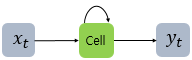

RNN은 은닉층의 노드의 결과를 출력층으로 보내면서 동시에 은닉층 노드의 다음 계산의 입력으로 활용

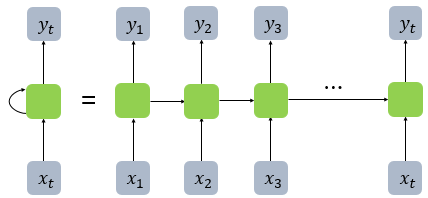

출력층 방향, 다음 시점 t+1의 자신에게 보내는 값을 은닉 상태(hidden state)라고 함 (t-1 시점의 은닉 상태값은 t 시점의 입력값으로 사용)

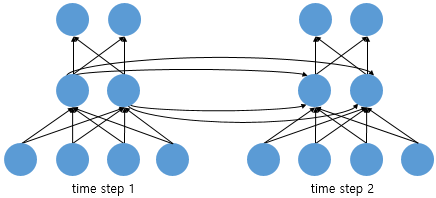

 **깊은 순환 신경망 구성 (여러 은닉층)**

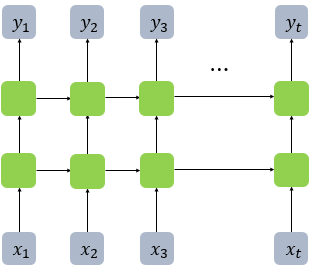

Pytorch에서의 RNN

```
nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
```

* (batch_size, timesteps, input_size) = (배치 크기 × 시점의 수 × 매 시점마다 들어가는 입력)
* num_layers = 은닉층 개수


RNN 셀의 리턴값
1. 첫 번째 리턴값: 마지막 층에서 모든 시점(timesteps)의 은닉 상태
2. 두 번째 리턴값: 모든 층에서 마지막 시점(timestep)의 은닉 상태

출처: PyTorch로 시작하는 딥러닝 입문 (https://wikidocs.net/60690)

In [ ]:
tmp = torch.randn((200, 100, 1))
tmp.shape

torch.Size([200, 100, 1])

In [ ]:
rnn_cell = nn.RNN(1, 50, num_layers=2, batch_first=True, dropout=0.5)
tmp_output, tmp_h0 = rnn_cell(tmp)
tmp_output.shape # 첫 번째 리턴값

torch.Size([200, 100, 50])

In [ ]:
tmp_h0.shape # 두 번째 리턴값

torch.Size([2, 200, 50])

예제 문제의 경우 다대일 (many-to-one) 문제 -> 마지막 층에서 마지막 시점의 은닉상태를 활용

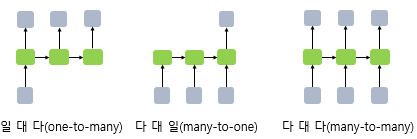

In [ ]:
batch_index = 0
print(tmp_output[batch_index, 99, :])

tensor([-0.1866, -0.2677,  0.1912, -0.2035, -0.0723, -0.1450,  0.0533, -0.0651,
         0.0672,  0.1266,  0.1109, -0.2166,  0.0799,  0.2718,  0.1974, -0.2952,
         0.2588, -0.0714,  0.3904,  0.1139, -0.0529,  0.0060, -0.1213, -0.1026,
        -0.0327,  0.1776,  0.1230, -0.2628,  0.3266,  0.1369,  0.1135, -0.0195,
         0.3777,  0.1391,  0.2138,  0.3850, -0.3654, -0.0815, -0.0227,  0.1592,
        -0.1877, -0.0190,  0.0381,  0.2039, -0.3348, -0.3970,  0.2791,  0.1261,
        -0.2087,  0.2358], grad_fn=<SliceBackward0>)


In [ ]:
print(tmp_output[batch_index, -1])

tensor([-0.1866, -0.2677,  0.1912, -0.2035, -0.0723, -0.1450,  0.0533, -0.0651,
         0.0672,  0.1266,  0.1109, -0.2166,  0.0799,  0.2718,  0.1974, -0.2952,
         0.2588, -0.0714,  0.3904,  0.1139, -0.0529,  0.0060, -0.1213, -0.1026,
        -0.0327,  0.1776,  0.1230, -0.2628,  0.3266,  0.1369,  0.1135, -0.0195,
         0.3777,  0.1391,  0.2138,  0.3850, -0.3654, -0.0815, -0.0227,  0.1592,
        -0.1877, -0.0190,  0.0381,  0.2039, -0.3348, -0.3970,  0.2791,  0.1261,
        -0.2087,  0.2358], grad_fn=<SelectBackward0>)


In [ ]:
class RNN_net(nn.Module):
    def __init__(self):
        super(RNN_net, self).__init__()

        self.rnn = nn.RNN(1, 50, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

RNN_predictor = RNN_net()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(RNN_predictor.parameters(), lr = 1e-3)

In [ ]:
for epoch in range(10):
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = RNN_predictor(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

    print("loss of {} epoch: {}".format(epoch, loss.item()))

loss of 0 epoch: 0.10733231902122498
loss of 1 epoch: 0.05577545985579491
loss of 2 epoch: 0.030704833567142487
loss of 3 epoch: 0.015668772161006927
loss of 4 epoch: 0.01490668673068285
loss of 5 epoch: 0.013478594832122326
loss of 6 epoch: 0.012611099518835545
loss of 7 epoch: 0.008103480562567711
loss of 8 epoch: 0.009228422306478024
loss of 9 epoch: 0.007903529331088066


In [ ]:
RNN_predictor.eval()
with torch.no_grad():
    mae = []
    for X_test, y in test_loader:
        y_pred = RNN_predictor(X_test)
        mae.append(torch.mean(torch.abs(y-y_pred)).item())

    # 정확도 출력
    mae = np.mean(mae)
    print(f'예측 오류: {mae:.2f}\n')

예측 오류: 0.05



## 미래 데이터 예측

In [ ]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

In [ ]:
X = X_new.copy()
for step_ahead in range(10):
    y_pred_one = MLP_predictor(torch.FloatTensor(X[:, step_ahead:,:]).view(1,n_steps))
    y_pred_one = np.array([y_pred_one.item()])[:, np.newaxis, np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1) # 예측한 값을 다시 학습 데이터셋과 결합

Y_pred = X[:, n_steps:]

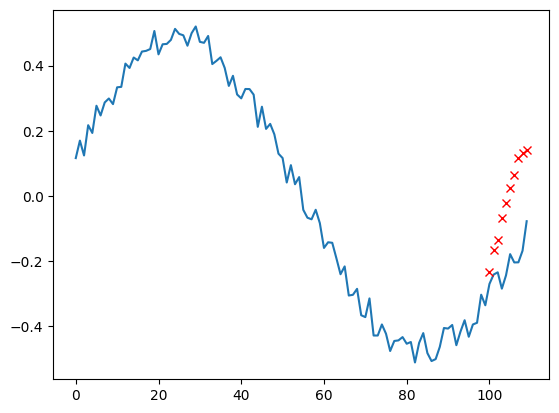

In [ ]:
plt.plot(series[0,:])
plt.plot(np.arange(n_steps,n_steps+10),Y_pred.squeeze(), 'rx')
plt.show()

In [ ]:
X = X_new.copy()
for step_ahead in range(10):
    y_pred_one = RNN_predictor(torch.FloatTensor(X[:, step_ahead:,:]))
    y_pred_one = np.array([y_pred_one.item()])[:, np.newaxis, np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1) # 예측한 값을 다시 학습 데이터셋과 결합

Y_pred = X[:, n_steps:]

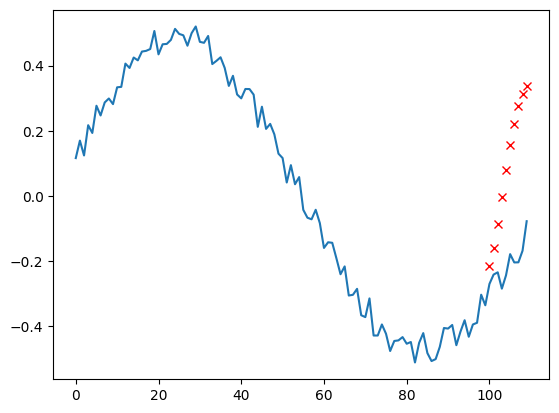

In [ ]:
plt.plot(series[0,:])
plt.plot(np.arange(n_steps,n_steps+10),Y_pred.squeeze(), 'rx')
plt.show()